In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Batting", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Batting", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Batting", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Cut', 'Drive', 'Leg Shot', 'PullShot', 'Scoop', 'Straight', 'Sweep']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 5814
Total validation images: 1494
Total test images: 1863
Total images in dataset: 9171


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 5168
Validation images (excluding 'random_occlusion'): 1328
Test images (excluding 'random_occlusion'): 1656
Total images (excluding 'random_occlusion'): 8152


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'random_occlusion', 'blur', 'lens_flare', 'dirty_lens', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original', 'motion_blur'}
Validation folders considered: {'random_occlusion', 'blur', 'lens_flare', 'dirty_lens', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original', 'motion_blur'}
Test folders considered: {'random_occlusion', 'blur', 'lens_flare', 'dirty_lens', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original', 'motion_blur'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Batting", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Batting", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Batting", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Cut', 'Drive', 'Leg Shot', 'PullShot', 'Scoop', 'Straight', 'Sweep']
Final Training images: 5168
Final Validation images: 1328
Final Test images: 1656
Total images after filtering: 8152


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'blur', 'lens_flare', 'dirty_lens', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original', 'motion_blur'}
Validation folders considered: {'blur', 'lens_flare', 'dirty_lens', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original', 'motion_blur'}
Test folders considered: {'blur', 'lens_flare', 'dirty_lens', 'chromatic_aberration', 'low_resolution', 'gaussian_noise', 'original', 'motion_blur'}


In [7]:
# -----------------------------
# 2. Define Swin Transformer Model from Scratch
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import time
import math
from typing import Optional

def window_partition(x, window_size):
    """
    Partition into non-overlapping windows
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    """
    Reverse window partition
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class PatchEmbedding(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else None
        
    def forward(self, x):
        """Forward function."""
        # padding
        _, _, H, W = x.size()
        if W % self.patch_size != 0:
            x = F.pad(x, (0, self.patch_size - W % self.patch_size))
        if H % self.patch_size != 0:
            x = F.pad(x, (0, 0, 0, self.patch_size - H % self.patch_size))
            
        x = self.proj(x)  # B C Wh Ww
        if self.norm is not None:
            Wh, Ww = x.size(2), x.size(3)
            x = x.flatten(2).transpose(1, 2)
            x = self.norm(x)
            x = x.transpose(1, 2).view(-1, self.embed_dim, Wh, Ww)
        return x

class PatchMerging(nn.Module):
    """Patch Merging Layer"""
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)
    
    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        
        x = x.view(B, H, W, C)
        
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C
        
        x = self.norm(x)
        x = self.reduction(x)
        
        return x

class WindowAttention(nn.Module):
    """Window based multi-head self attention (W-MSA) module with relative position bias"""
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        
        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        
        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij'))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, mask: Optional[torch.Tensor] = None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)
        
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
            
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class SwinTransformerBlock(nn.Module):
    """Swin Transformer Block"""
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
                    
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
            
        self.register_buffer("attn_mask", attn_mask)
    
    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        
        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)
        
        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            
        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C
        
        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        
        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        
        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        
        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output

class Mlp(nn.Module):
    """Multi-Layer Perceptron"""
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class BasicLayer(nn.Module):
    """A basic Swin Transformer layer for one stage"""
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        
        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim, input_resolution=input_resolution,
                num_heads=num_heads, window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop, attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])
        
        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None
            
    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

class MySwinTransformer(nn.Module):
    """Swin Transformer Implementation from Scratch"""
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=4,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True, use_checkpoint=False):
        super().__init__()
        
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        
        # split image into non-overlapping patches
        self.patch_embed = PatchEmbedding(
            patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches = (img_size // patch_size) ** 2
        patches_resolution = self.patch_embed.patches_resolution = [img_size // patch_size, img_size // patch_size]
        self.patches_resolution = patches_resolution
        
        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            nn.init.trunc_normal_(self.absolute_pos_embed, std=.02)
            
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        
        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                  patches_resolution[1] // (2 ** i_layer)),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint)
            self.layers.append(layer)
            
        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        
        # Flatten for transformer blocks
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        
        for layer in self.layers:
            x = layer(x)
            
        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Swin-Tiny configuration
model = MySwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=len(classes),
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
    mlp_ratio=4.0,
    qkv_bias=True,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=False
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)

print("Swin Transformer Model Summary:")
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary generation failed - this is normal for complex architectures")
    print(f"Model created successfully with {sum(p.numel() for p in model.parameters()):,} parameters")

Swin Transformer Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2             [-1, 3136, 96]             192
    PatchEmbedding-3           [-1, 96, 56, 56]               0
           Dropout-4           [-1, 96, 56, 56]               0
         LayerNorm-5             [-1, 3136, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12             [-1, 3136, 96]               0
        LayerNorm-13             [-1, 3136, 96]             192
       


üöÄ Starting Swin Transformer Training for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:58<00:00,  1.36it/s, Loss=1.9298, Acc=0.2465]


‚úÖ Training completed in 118.73s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:23<00:00,  1.75it/s, Loss=1.8762, Acc=0.2545]


‚úÖ Validation completed in 23.95s
üåü New best Swin Transformer model found! Validation Accuracy: 0.2545

üìä Epoch 1 Summary:
‚îÇ Train Loss: 1.9298 | Train Acc: 0.2465
‚îÇ Val Loss:   1.8762 | Val Acc:   0.2545
‚îÇ Train Time: 118.73s | Val Time: 23.95s
‚îÇ Total Epoch Time: 142.69s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8447, Acc=0.2535]


‚úÖ Training completed in 96.51s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.86it/s, Loss=1.8291, Acc=0.2108]


‚úÖ Validation completed in 14.66s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 1.8447 | Train Acc: 0.2535
‚îÇ Val Loss:   1.8291 | Val Acc:   0.2108
‚îÇ Train Time: 96.51s | Val Time: 14.66s
‚îÇ Total Epoch Time: 111.18s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8368, Acc=0.2438]


‚úÖ Training completed in 97.07s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8629, Acc=0.2432]


‚úÖ Validation completed in 14.72s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 1.8368 | Train Acc: 0.2438
‚îÇ Val Loss:   1.8629 | Val Acc:   0.2432
‚îÇ Train Time: 97.07s | Val Time: 14.72s
‚îÇ Total Epoch Time: 111.79s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8482, Acc=0.2303]


‚úÖ Training completed in 96.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8700, Acc=0.2410]


‚úÖ Validation completed in 14.57s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 1.8482 | Train Acc: 0.2303
‚îÇ Val Loss:   1.8700 | Val Acc:   0.2410
‚îÇ Train Time: 96.98s | Val Time: 14.57s
‚îÇ Total Epoch Time: 111.55s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8370, Acc=0.2297]


‚úÖ Training completed in 96.89s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8420, Acc=0.2048]


‚úÖ Validation completed in 14.60s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 1.8370 | Train Acc: 0.2297
‚îÇ Val Loss:   1.8420 | Val Acc:   0.2048
‚îÇ Train Time: 96.89s | Val Time: 14.60s
‚îÇ Total Epoch Time: 111.50s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8313, Acc=0.2366]


‚úÖ Training completed in 97.16s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8608, Acc=0.2372]


‚úÖ Validation completed in 14.74s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 1.8313 | Train Acc: 0.2366
‚îÇ Val Loss:   1.8608 | Val Acc:   0.2372
‚îÇ Train Time: 97.16s | Val Time: 14.74s
‚îÇ Total Epoch Time: 111.90s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8319, Acc=0.2324]


‚úÖ Training completed in 97.29s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.81it/s, Loss=1.8600, Acc=0.2410]


‚úÖ Validation completed in 14.97s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 1.8319 | Train Acc: 0.2324
‚îÇ Val Loss:   1.8600 | Val Acc:   0.2410
‚îÇ Train Time: 97.29s | Val Time: 14.97s
‚îÇ Total Epoch Time: 112.26s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.66it/s, Loss=1.8243, Acc=0.2330]


‚úÖ Training completed in 97.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.82it/s, Loss=1.8427, Acc=0.2169]


‚úÖ Validation completed in 14.91s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 1.8243 | Train Acc: 0.2330
‚îÇ Val Loss:   1.8427 | Val Acc:   0.2169
‚îÇ Train Time: 97.50s | Val Time: 14.91s
‚îÇ Total Epoch Time: 112.42s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:39<00:00,  1.63it/s, Loss=1.8244, Acc=0.2345]


‚úÖ Training completed in 99.15s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8351, Acc=0.2432]


‚úÖ Validation completed in 14.73s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 1.8244 | Train Acc: 0.2345
‚îÇ Val Loss:   1.8351 | Val Acc:   0.2432
‚îÇ Train Time: 99.15s | Val Time: 14.73s
‚îÇ Total Epoch Time: 113.88s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:38<00:00,  1.65it/s, Loss=1.8235, Acc=0.2277]


‚úÖ Training completed in 98.10s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8411, Acc=0.2410]


‚úÖ Validation completed in 14.54s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 1.8235 | Train Acc: 0.2277
‚îÇ Val Loss:   1.8411 | Val Acc:   0.2410
‚îÇ Train Time: 98.10s | Val Time: 14.54s
‚îÇ Total Epoch Time: 112.64s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.66it/s, Loss=1.8251, Acc=0.2351]


‚úÖ Training completed in 97.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.84it/s, Loss=1.8437, Acc=0.2410]


‚úÖ Validation completed in 14.81s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 1.8251 | Train Acc: 0.2351
‚îÇ Val Loss:   1.8437 | Val Acc:   0.2410
‚îÇ Train Time: 97.83s | Val Time: 14.81s
‚îÇ Total Epoch Time: 112.65s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.66it/s, Loss=1.8231, Acc=0.2363]


‚úÖ Training completed in 97.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.83it/s, Loss=1.8375, Acc=0.2410]


‚úÖ Validation completed in 14.85s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 1.8231 | Train Acc: 0.2363
‚îÇ Val Loss:   1.8375 | Val Acc:   0.2410
‚îÇ Train Time: 97.48s | Val Time: 14.85s
‚îÇ Total Epoch Time: 112.33s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.66it/s, Loss=1.8191, Acc=0.2397]


‚úÖ Training completed in 97.33s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8345, Acc=0.2410]


‚úÖ Validation completed in 14.73s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 1.8191 | Train Acc: 0.2397
‚îÇ Val Loss:   1.8345 | Val Acc:   0.2410
‚îÇ Train Time: 97.33s | Val Time: 14.73s
‚îÇ Total Epoch Time: 112.06s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8200, Acc=0.2432]


‚úÖ Training completed in 97.18s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8379, Acc=0.2410]


‚úÖ Validation completed in 14.55s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 1.8200 | Train Acc: 0.2432
‚îÇ Val Loss:   1.8379 | Val Acc:   0.2410
‚îÇ Train Time: 97.18s | Val Time: 14.55s
‚îÇ Total Epoch Time: 111.73s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8215, Acc=0.2436]


‚úÖ Training completed in 96.44s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.90it/s, Loss=1.8372, Acc=0.2410]


‚úÖ Validation completed in 14.48s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 1.8215 | Train Acc: 0.2436
‚îÇ Val Loss:   1.8372 | Val Acc:   0.2410
‚îÇ Train Time: 96.44s | Val Time: 14.48s
‚îÇ Total Epoch Time: 110.92s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8219, Acc=0.2361]


‚úÖ Training completed in 96.49s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.86it/s, Loss=1.8354, Acc=0.2169]


‚úÖ Validation completed in 14.68s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 1.8219 | Train Acc: 0.2361
‚îÇ Val Loss:   1.8354 | Val Acc:   0.2169
‚îÇ Train Time: 96.49s | Val Time: 14.68s
‚îÇ Total Epoch Time: 111.18s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8202, Acc=0.2330]


‚úÖ Training completed in 96.55s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.93it/s, Loss=1.8413, Acc=0.2410]


‚úÖ Validation completed in 14.33s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 1.8202 | Train Acc: 0.2330
‚îÇ Val Loss:   1.8413 | Val Acc:   0.2410
‚îÇ Train Time: 96.55s | Val Time: 14.33s
‚îÇ Total Epoch Time: 110.88s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8186, Acc=0.2417]


‚úÖ Training completed in 96.74s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.83it/s, Loss=1.8339, Acc=0.2410]


‚úÖ Validation completed in 14.84s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 1.8186 | Train Acc: 0.2417
‚îÇ Val Loss:   1.8339 | Val Acc:   0.2410
‚îÇ Train Time: 96.74s | Val Time: 14.84s
‚îÇ Total Epoch Time: 111.58s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:38<00:00,  1.65it/s, Loss=1.8200, Acc=0.2407]


‚úÖ Training completed in 98.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8357, Acc=0.2410]


‚úÖ Validation completed in 14.61s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 1.8200 | Train Acc: 0.2407
‚îÇ Val Loss:   1.8357 | Val Acc:   0.2410
‚îÇ Train Time: 98.06s | Val Time: 14.61s
‚îÇ Total Epoch Time: 112.68s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8193, Acc=0.2459]


‚úÖ Training completed in 96.78s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8366, Acc=0.2410]


‚úÖ Validation completed in 14.72s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 1.8193 | Train Acc: 0.2459
‚îÇ Val Loss:   1.8366 | Val Acc:   0.2410
‚îÇ Train Time: 96.78s | Val Time: 14.72s
‚îÇ Total Epoch Time: 111.51s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8194, Acc=0.2423]


‚úÖ Training completed in 97.05s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.87it/s, Loss=1.8397, Acc=0.2048]


‚úÖ Validation completed in 14.62s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 1.8194 | Train Acc: 0.2423
‚îÇ Val Loss:   1.8397 | Val Acc:   0.2048
‚îÇ Train Time: 97.05s | Val Time: 14.62s
‚îÇ Total Epoch Time: 111.67s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8185, Acc=0.2419]


‚úÖ Training completed in 97.17s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.84it/s, Loss=1.8356, Acc=0.2169]


‚úÖ Validation completed in 14.82s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 1.8185 | Train Acc: 0.2419
‚îÇ Val Loss:   1.8356 | Val Acc:   0.2169
‚îÇ Train Time: 97.17s | Val Time: 14.82s
‚îÇ Total Epoch Time: 112.00s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8195, Acc=0.2353]


‚úÖ Training completed in 96.63s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.82it/s, Loss=1.8356, Acc=0.2410]


‚úÖ Validation completed in 14.90s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 1.8195 | Train Acc: 0.2353
‚îÇ Val Loss:   1.8356 | Val Acc:   0.2410
‚îÇ Train Time: 96.63s | Val Time: 14.90s
‚îÇ Total Epoch Time: 111.53s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8195, Acc=0.2386]


‚úÖ Training completed in 97.08s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8352, Acc=0.2410]


‚úÖ Validation completed in 14.60s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 1.8195 | Train Acc: 0.2386
‚îÇ Val Loss:   1.8352 | Val Acc:   0.2410
‚îÇ Train Time: 97.08s | Val Time: 14.60s
‚îÇ Total Epoch Time: 111.69s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8179, Acc=0.2425]


‚úÖ Training completed in 96.90s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8352, Acc=0.2169]


‚úÖ Validation completed in 14.74s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 1.8179 | Train Acc: 0.2425
‚îÇ Val Loss:   1.8352 | Val Acc:   0.2169
‚îÇ Train Time: 96.90s | Val Time: 14.74s
‚îÇ Total Epoch Time: 111.64s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8185, Acc=0.2365]


‚úÖ Training completed in 96.75s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8414, Acc=0.2169]


‚úÖ Validation completed in 14.61s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 1.8185 | Train Acc: 0.2365
‚îÇ Val Loss:   1.8414 | Val Acc:   0.2169
‚îÇ Train Time: 96.75s | Val Time: 14.61s
‚îÇ Total Epoch Time: 111.36s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8189, Acc=0.2382]


‚úÖ Training completed in 96.73s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8400, Acc=0.2169]


‚úÖ Validation completed in 14.54s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 1.8189 | Train Acc: 0.2382
‚îÇ Val Loss:   1.8400 | Val Acc:   0.2169
‚îÇ Train Time: 96.73s | Val Time: 14.54s
‚îÇ Total Epoch Time: 111.27s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8196, Acc=0.2347]


‚úÖ Training completed in 96.95s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8388, Acc=0.2410]


‚úÖ Validation completed in 14.52s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 1.8196 | Train Acc: 0.2347
‚îÇ Val Loss:   1.8388 | Val Acc:   0.2410
‚îÇ Train Time: 96.95s | Val Time: 14.52s
‚îÇ Total Epoch Time: 111.47s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8183, Acc=0.2432]


‚úÖ Training completed in 97.29s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8341, Acc=0.2410]


‚úÖ Validation completed in 14.55s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 1.8183 | Train Acc: 0.2432
‚îÇ Val Loss:   1.8341 | Val Acc:   0.2410
‚îÇ Train Time: 97.29s | Val Time: 14.55s
‚îÇ Total Epoch Time: 111.84s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8181, Acc=0.2407]


‚úÖ Training completed in 96.74s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.81it/s, Loss=1.8371, Acc=0.2410]


‚úÖ Validation completed in 14.95s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 1.8181 | Train Acc: 0.2407
‚îÇ Val Loss:   1.8371 | Val Acc:   0.2410
‚îÇ Train Time: 96.74s | Val Time: 14.95s
‚îÇ Total Epoch Time: 111.70s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8197, Acc=0.2401]


‚úÖ Training completed in 96.76s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8362, Acc=0.2410]


‚úÖ Validation completed in 14.56s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 1.8197 | Train Acc: 0.2401
‚îÇ Val Loss:   1.8362 | Val Acc:   0.2410
‚îÇ Train Time: 96.76s | Val Time: 14.56s
‚îÇ Total Epoch Time: 111.32s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8179, Acc=0.2419]


‚úÖ Training completed in 96.44s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8349, Acc=0.2410]


‚úÖ Validation completed in 14.59s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 1.8179 | Train Acc: 0.2419
‚îÇ Val Loss:   1.8349 | Val Acc:   0.2410
‚îÇ Train Time: 96.44s | Val Time: 14.59s
‚îÇ Total Epoch Time: 111.03s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8169, Acc=0.2459]


‚úÖ Training completed in 96.98s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.83it/s, Loss=1.8346, Acc=0.2410]


‚úÖ Validation completed in 14.86s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 1.8169 | Train Acc: 0.2459
‚îÇ Val Loss:   1.8346 | Val Acc:   0.2410
‚îÇ Train Time: 96.98s | Val Time: 14.86s
‚îÇ Total Epoch Time: 111.84s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8174, Acc=0.2415]


‚úÖ Training completed in 97.29s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.86it/s, Loss=1.8369, Acc=0.2410]


‚úÖ Validation completed in 14.69s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 1.8174 | Train Acc: 0.2415
‚îÇ Val Loss:   1.8369 | Val Acc:   0.2410
‚îÇ Train Time: 97.29s | Val Time: 14.69s
‚îÇ Total Epoch Time: 111.98s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8181, Acc=0.2419]


‚úÖ Training completed in 97.26s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.84it/s, Loss=1.8377, Acc=0.2410]


‚úÖ Validation completed in 14.81s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 1.8181 | Train Acc: 0.2419
‚îÇ Val Loss:   1.8377 | Val Acc:   0.2410
‚îÇ Train Time: 97.26s | Val Time: 14.81s
‚îÇ Total Epoch Time: 112.07s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8172, Acc=0.2442]


‚úÖ Training completed in 97.26s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.84it/s, Loss=1.8343, Acc=0.2410]


‚úÖ Validation completed in 14.79s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 1.8172 | Train Acc: 0.2442
‚îÇ Val Loss:   1.8343 | Val Acc:   0.2410
‚îÇ Train Time: 97.26s | Val Time: 14.79s
‚îÇ Total Epoch Time: 112.06s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8183, Acc=0.2455]


‚úÖ Training completed in 97.19s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.80it/s, Loss=1.8337, Acc=0.2410]


‚úÖ Validation completed in 14.99s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 1.8183 | Train Acc: 0.2455
‚îÇ Val Loss:   1.8337 | Val Acc:   0.2410
‚îÇ Train Time: 97.19s | Val Time: 14.99s
‚îÇ Total Epoch Time: 112.18s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.66it/s, Loss=1.8175, Acc=0.2461]


‚úÖ Training completed in 97.46s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8345, Acc=0.2410]


‚úÖ Validation completed in 14.74s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 1.8175 | Train Acc: 0.2461
‚îÇ Val Loss:   1.8345 | Val Acc:   0.2410
‚îÇ Train Time: 97.46s | Val Time: 14.74s
‚îÇ Total Epoch Time: 112.21s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8176, Acc=0.2459]


‚úÖ Training completed in 96.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.86it/s, Loss=1.8336, Acc=0.2410]


‚úÖ Validation completed in 14.70s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 1.8176 | Train Acc: 0.2459
‚îÇ Val Loss:   1.8336 | Val Acc:   0.2410
‚îÇ Train Time: 96.91s | Val Time: 14.70s
‚îÇ Total Epoch Time: 111.62s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8175, Acc=0.2434]


‚úÖ Training completed in 97.01s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.88it/s, Loss=1.8347, Acc=0.2410]


‚úÖ Validation completed in 14.60s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 1.8175 | Train Acc: 0.2434
‚îÇ Val Loss:   1.8347 | Val Acc:   0.2410
‚îÇ Train Time: 97.01s | Val Time: 14.60s
‚îÇ Total Epoch Time: 111.61s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.67it/s, Loss=1.8178, Acc=0.2465]


‚úÖ Training completed in 97.06s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.90it/s, Loss=1.8340, Acc=0.2410]


‚úÖ Validation completed in 14.49s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 1.8178 | Train Acc: 0.2465
‚îÇ Val Loss:   1.8340 | Val Acc:   0.2410
‚îÇ Train Time: 97.06s | Val Time: 14.49s
‚îÇ Total Epoch Time: 111.56s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8181, Acc=0.2461]


‚úÖ Training completed in 96.48s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.91it/s, Loss=1.8339, Acc=0.2410]


‚úÖ Validation completed in 14.46s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 1.8181 | Train Acc: 0.2461
‚îÇ Val Loss:   1.8339 | Val Acc:   0.2410
‚îÇ Train Time: 96.48s | Val Time: 14.46s
‚îÇ Total Epoch Time: 110.94s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8175, Acc=0.2407]


‚úÖ Training completed in 96.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.90it/s, Loss=1.8336, Acc=0.2410]


‚úÖ Validation completed in 14.46s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 1.8175 | Train Acc: 0.2407
‚îÇ Val Loss:   1.8336 | Val Acc:   0.2410
‚îÇ Train Time: 96.20s | Val Time: 14.46s
‚îÇ Total Epoch Time: 110.67s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8178, Acc=0.2390]


‚úÖ Training completed in 96.58s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:15<00:00,  2.78it/s, Loss=1.8341, Acc=0.2410]


‚úÖ Validation completed in 15.11s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 1.8178 | Train Acc: 0.2390
‚îÇ Val Loss:   1.8341 | Val Acc:   0.2410
‚îÇ Train Time: 96.58s | Val Time: 15.11s
‚îÇ Total Epoch Time: 111.69s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:37<00:00,  1.66it/s, Loss=1.8170, Acc=0.2454]


‚úÖ Training completed in 97.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.85it/s, Loss=1.8329, Acc=0.2410]


‚úÖ Validation completed in 14.75s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 1.8170 | Train Acc: 0.2454
‚îÇ Val Loss:   1.8329 | Val Acc:   0.2410
‚îÇ Train Time: 97.34s | Val Time: 14.75s
‚îÇ Total Epoch Time: 112.10s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8172, Acc=0.2461]


‚úÖ Training completed in 96.75s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8401, Acc=0.2410]


‚úÖ Validation completed in 14.52s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 1.8172 | Train Acc: 0.2461
‚îÇ Val Loss:   1.8401 | Val Acc:   0.2410
‚îÇ Train Time: 96.75s | Val Time: 14.52s
‚îÇ Total Epoch Time: 111.27s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8167, Acc=0.2417]


‚úÖ Training completed in 96.96s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.91it/s, Loss=1.8348, Acc=0.2410]


‚úÖ Validation completed in 14.42s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 1.8167 | Train Acc: 0.2417
‚îÇ Val Loss:   1.8348 | Val Acc:   0.2410
‚îÇ Train Time: 96.96s | Val Time: 14.42s
‚îÇ Total Epoch Time: 111.39s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8170, Acc=0.2430]


‚úÖ Training completed in 96.97s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.82it/s, Loss=1.8334, Acc=0.2410]


‚úÖ Validation completed in 14.90s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 1.8170 | Train Acc: 0.2430
‚îÇ Val Loss:   1.8334 | Val Acc:   0.2410
‚îÇ Train Time: 96.97s | Val Time: 14.90s
‚îÇ Total Epoch Time: 111.88s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.67it/s, Loss=1.8172, Acc=0.2442]


‚úÖ Training completed in 97.00s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.87it/s, Loss=1.8328, Acc=0.2410]


‚úÖ Validation completed in 14.63s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 1.8172 | Train Acc: 0.2442
‚îÇ Val Loss:   1.8328 | Val Acc:   0.2410
‚îÇ Train Time: 97.00s | Val Time: 14.63s
‚îÇ Total Epoch Time: 111.63s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 162/162 [01:36<00:00,  1.68it/s, Loss=1.8170, Acc=0.2459]


‚úÖ Training completed in 96.70s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42/42 [00:14<00:00,  2.89it/s, Loss=1.8332, Acc=0.2410]


‚úÖ Validation completed in 14.55s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 1.8170 | Train Acc: 0.2459
‚îÇ Val Loss:   1.8332 | Val Acc:   0.2410
‚îÇ Train Time: 96.70s | Val Time: 14.55s
‚îÇ Total Epoch Time: 111.26s
‚îÇ Best Val Acc: 0.2545 (Epoch 1)
‚îÇ GPU Memory: 0.4GB / 4.0GB

üíæ Best Swin Transformer model saved as 'best_swin_transformer_model.pth'
üìä Best model stats:
‚îÇ Best Epoch: 1
‚îÇ Best Val Acc: 0.2545

üíæ Swin Transformer training history saved to 'swin_transformer_training_history.csv'

üéâ Swin Transformer Training Complete!
Total Training Time: 5617.85s (93.6 minutes)
Average Epoch Time: 112.36s

‚è±Ô∏è  Epoch Timing Breakdown:
‚îÇ Epoch 1: 142.69s
‚îÇ Epoch 2: 111.18s
‚îÇ Epoch 3: 111.79s
‚îÇ Epoch 4: 111.55s
‚îÇ Epoch 5: 111.50s
‚îÇ Epoch 6: 111.90s
‚îÇ Epoch 7: 112.26s
‚îÇ Epoch 8: 112.42s
‚îÇ Epoch 9: 113.88s
‚îÇ Epoch 10: 112.64s
‚îÇ Epoch 11: 112.65s
‚îÇ Epoch 12: 112.33s
‚îÇ Epoch 13: 112.06s
‚îÇ Epoch 14: 111.73s
‚îÇ Epoch 15: 110.92s
‚îÇ Epoch 16: 111

Testing Swin Transformer: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 52/52 [00:27<00:00,  1.90it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

‚úÖ Swin Transformer Testing completed in 27.38s

üìã Swin Transformer Classification Report:
              precision    recall  f1-score   support

         Cut       0.24      1.00      0.39       400
       Drive       0.00      0.00      0.00       336
    Leg Shot       0.00      0.00      0.00       136
    PullShot       0.00      0.00      0.00       192
       Scoop       0.00      0.00      0.00       360
    Straight       0.00      0.00      0.00       144
       Sweep       0.00      0.00      0.00        88

    accuracy                           0.24      1656
   macro avg       0.03      0.14      0.06      1656
weighted avg       0.06      0.24      0.09      1656

üéØ Swin Transformer Test Accuracy: 0.2415

üìä Swin Transformer Model Performance Summary:
‚îÇ Best Validation Acc:  0.2545 (Epoch 1)
‚îÇ Final Test Accuracy:  0.2415
‚îÇ Val-Test Gap:         0.0130


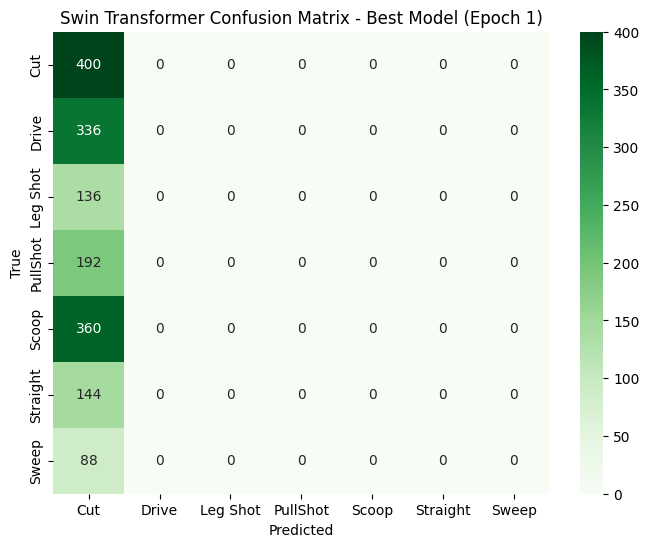

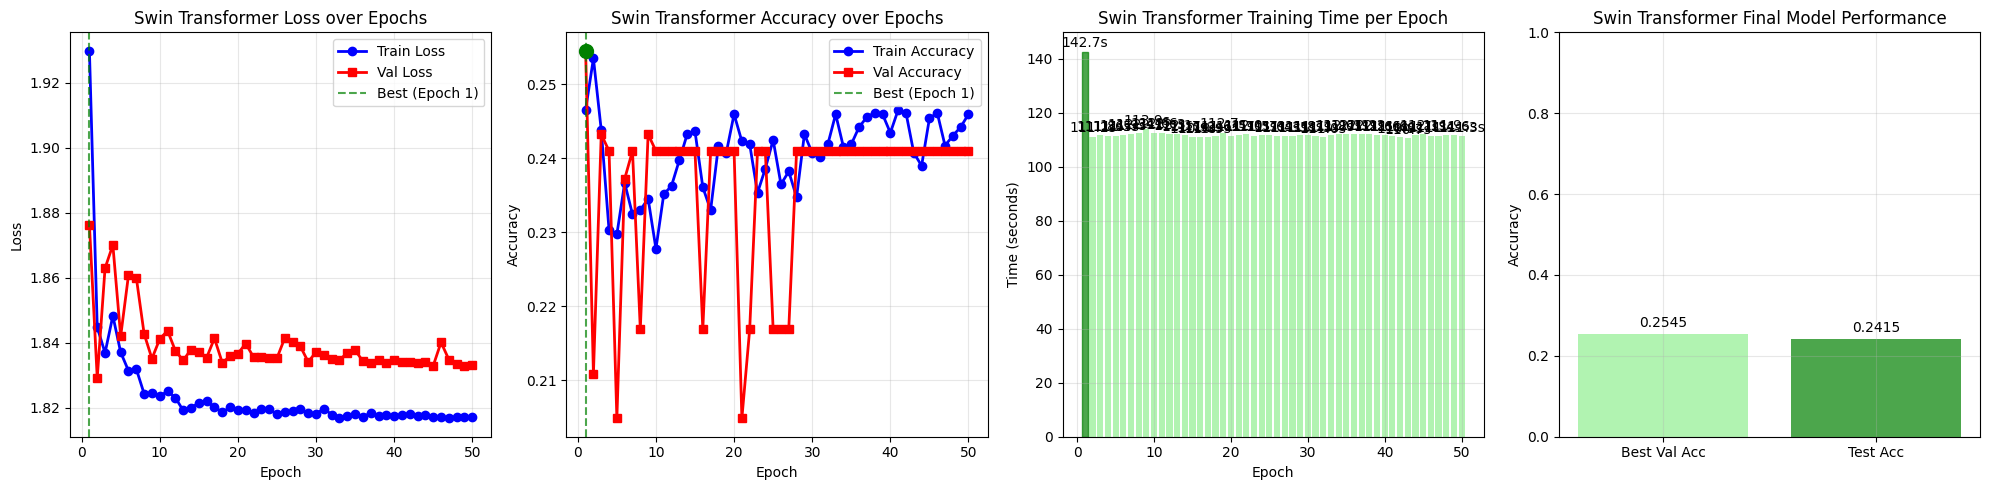


‚è∞ Swin Transformer Final Timing Summary:
‚îÇ Total Training: 5617.85s
‚îÇ Average per Epoch: 112.36s
‚îÇ Testing Time: 27.38s
‚îÇ Total Runtime: 5645.23s

üíæ Swin Transformer Files saved:
‚îÇ best_swin_transformer_model.pth - Best validation accuracy model
‚îÇ swin_transformer_training_history.csv - Training metrics for later plotting

üèóÔ∏è  Swin Transformer Architecture Summary:
‚îÇ Total Parameters: 27,524,737
‚îÇ Trainable Parameters: 27,524,737
‚îÇ Model Size: 105.00 MB
‚îÇ Input Size: 224x224x3
‚îÇ Patch Size: 4x4
‚îÇ Window Size: 7x7
‚îÇ Embed Dimension: 96
‚îÇ Depths: [2, 2, 6, 2]
‚îÇ Number of Heads: [3, 6, 12, 24]
‚îÇ Drop Path Rate: 0.1
‚îÇ Output Classes: 7
‚îÇ Hierarchical Structure: Yes
‚îÇ Shifted Windows: Yes
‚îÇ Relative Position Bias: Yes


In [9]:
# -----------------------------
# 4. Training Loop with Best Model Saving (Val Accuracy) - Swin Transformer
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

print(f"\nüöÄ Starting Swin Transformer Training for {epochs} epochs...")
print("=" * 80)

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc=f"Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc=f"Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model so far based on val_acc
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best Swin Transformer model found! Validation Accuracy: {val_acc:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_swin_transformer_model.pth')
    print(f"\nüíæ Best Swin Transformer model saved as 'best_swin_transformer_model.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history data to CSV
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}
history_df = pd.DataFrame(history_data)
history_df.to_csv('swin_transformer_training_history.csv', index=False)
print("\nüíæ Swin Transformer training history saved to 'swin_transformer_training_history.csv'")

# Training Summary
print(f"\nüéâ Swin Transformer Training Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")
print("\n‚è±Ô∏è  Epoch Timing Breakdown:")
for i, t in enumerate(epoch_times):
    print(f"‚îÇ Epoch {i+1}: {t:.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Swin Transformer Model for Testing...")

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best Swin Transformer model from epoch {best_epoch} loaded successfully!")
else:
    print("‚ö†Ô∏è  No best model found, using current model state")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()

test_pbar = tqdm(test_loader, desc="Testing Swin Transformer", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Swin Transformer Testing completed in {test_time:.2f}s")
print("\nüìã Swin Transformer Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Swin Transformer Test Accuracy: {test_accuracy:.4f}")

# Model Performance Summary
print(f"\nüìä Swin Transformer Model Performance Summary:")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Swin Transformer Confusion Matrix - Best Model (Epoch {best_epoch})")
plt.show()

# -----------------------------
# 6. Enhanced Visualizations
# -----------------------------
plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 4, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.legend()
plt.title("Swin Transformer Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 4, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Swin Transformer Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Timing Plot
plt.subplot(1, 4, 3)
bars = plt.bar(range(1, epochs+1), epoch_times, color='lightgreen', alpha=0.7)
bars[best_epoch-1].set_color('green')
plt.title("Swin Transformer Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True, alpha=0.3)
for i, t in enumerate(epoch_times):
    plt.text(i+1, t+0.5, f'{t:.1f}s', ha='center', va='bottom')

# Performance Comparison
plt.subplot(1, 4, 4)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['lightgreen', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Swin Transformer Final Model Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n‚è∞ Swin Transformer Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

print(f"\nüíæ Swin Transformer Files saved:")
print(f"‚îÇ best_swin_transformer_model.pth - Best validation accuracy model")
print(f"‚îÇ swin_transformer_training_history.csv - Training metrics for later plotting")

# -----------------------------
# 7. Swin Transformer Architecture Summary
# -----------------------------
print(f"\nüèóÔ∏è  Swin Transformer Architecture Summary:")
print(f"‚îÇ Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"‚îÇ Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"‚îÇ Model Size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.2f} MB")
print(f"‚îÇ Input Size: 224x224x3")
print(f"‚îÇ Patch Size: 4x4")
print(f"‚îÇ Window Size: 7x7")
print(f"‚îÇ Embed Dimension: {model.embed_dim}")
print(f"‚îÇ Depths: {[2, 2, 6, 2]}")
print(f"‚îÇ Number of Heads: {[3, 6, 12, 24]}")
print(f"‚îÇ Drop Path Rate: 0.1")
print(f"‚îÇ Output Classes: {len(classes)}")
print(f"‚îÇ Hierarchical Structure: Yes")
print(f"‚îÇ Shifted Windows: Yes")
print(f"‚îÇ Relative Position Bias: Yes")